# Algorytmy macierzowe - eliminacja Gaussa dla macierzy rzadkich

*Wykonanie: Adrianna Łysik, Maksymilian Wojnar*

# Problem nr 8

**Kolumnowa rzadka eliminacja Gaussa w formacie CSC**

Treść ćwiczenia:

1. Proszę zaimplementować ustaloną z prowadzącym wersję eliminacji Cholesky’ego lub Gaussa dla macierzy rzadkiej używając ustalonego formatu macierzy rzadkiej.
2. Proszę również zaimplementować ustaloną z prowadzącym wersję eliminacji Cholesky’ego lub Gaussa dla macierzy gęstej.
3. Proszę zastosować skrypt massmatrix najlepiej w MATLABie do wygenerowania macierzy `massmatrix(0,18,2,0)` daje $nx = ny = 18 + 2 = 20$ oraz $n = 20 \cdot 20 = 400$ lub większej, proszę narysować wzór rzadkości macierzy `sky(A)`.
4. Proszę porównać czasy działania eliminacji rzadkiej i gęstej dla 3.
5. Proszę porównać zużycie pamięci eliminacji rzadkiej i gęstej dla 3.
6. Proszę zastosować skrypt massmatrix najlepiej w MATLABie do wygenerowania macierzy `massmatrix(1,13,3,0)` daje $nx = ny = 13 + 1 + 2 * 13 = 40$ oraz $n = 40 \cdot 40 = 1600$, proszę narysować wzór rzadkości macierzy `sky(A)`.
7. Proszę porównać czasy działania eliminacji rzadkiej i gęstej dla 6.
8. Proszę porównać zużycie pamięci eliminacji rzadkiej i gęstej dla 6.

**Importy i ustawienia wyświetlania**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import perf_counter
import sys
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (15, 10)

**Konwersja macierzy gęstej do rzadkiej w formacie CSC**

In [7]:
epsilon = 1e-14

class CSCMatrix:
    def __init__(self, matrix):
        if matrix is not None:
            self.dtype = matrix.dtype   # typ elementów macierzy
            self.shape = matrix.shape   # wymiary macierzy
            self.vals = []     # wartości elementów macierzy
            self.irn = []      # numery wierszy poszczególnych elementów
            self.colptr = [0]  # lista z indeksami kolejnych kolumn w vals, irn
            self.nnz = 0       # liczba elementów niezerowych macierzy

            self.from_dense(matrix)

    # konwersja do postaci rzadkiej
    def from_dense(self, matrix):
        for j in range(matrix.shape[1]):   # macierz jest przeglądana kolumnami
            for i in range(matrix.shape[0]):
                if not np.abs(matrix[i, j]) < epsilon: # jeśli element jest niezerowy
                    self.vals.append(matrix[i, j])  # zapisujemy jego wartość,
                    self.irn.append(i)              # numer wiersza
                    self.nnz += 1                   # i zwiększamy liczbę el. niezerowych

            self.colptr.append(self.nnz)  # po przejściu przez kolumnę zapisujemy indeks końca tej kolumny

# Ad 1

## Kolumnowa rzadka eliminacja Gaussa w formacie CSC

In [8]:
def csc_gauss_elimination(N, colptr, irn, vals):
    for k in range(N - 1):
        col_idx = colptr[k]
        while irn[col_idx] != k:  
            col_idx += 1
        akk = vals[col_idx] 

        elim_vals = vals[col_idx + 1:colptr[k + 1]]
        elim_rows = irn[col_idx + 1:colptr[k + 1]]

        if len(elim_vals) == 0: 
            continue

        for j in range(k + 1, N):
            col_j = vals[colptr[j]:colptr[j + 1]]
            rows_j = irn[colptr[j]:colptr[j + 1]]

            if k in rows_j:
                akj = col_j[np.where(rows_j == k)[0][0]]

                for r, v in zip(elim_rows, elim_vals):
                    if r not in irn[colptr[j]:colptr[j + 1]]:  
                        idx = np.where(irn[colptr[j]:colptr[j + 1]] > r)[0]
                        
                        if len(idx) != 0:
                            i = (colptr[j] + idx[0]) 
                        else:
                            i = colptr[j + 1]
                            
                        vals = np.concatenate((vals[:i, ], np.zeros(1), vals[i:, ]))
                        irn = np.concatenate((irn[:i, ], np.array([r]), irn[i:, ]))
                        
                        logic = colptr >= i
                        colptr += logic
                        
                    else:
                        i = colptr[j] + np.where(irn[colptr[j]:colptr[j + 1]] == r)[0][0]
                    vals[i] -= akj * (v / akk)
        vals[col_idx + 1:colptr[k + 1]] = 0

    k = 0
    for i in range(len(vals)):
        if vals[i] != 0:
            irn[k] = irn[i]
            vals[k] = vals[i]
            k += 1
        else:
            logic = colptr > k
            colptr -= logic

    irn, vals = irn[:k], vals[:k]

    return colptr, irn, vals

# Ad 2

## Eliminacja Gaussa dla macierzy gęstej

In [9]:
def dense_gauss_elimination(A):
    n = len(A)
    for k in range(n - 1):
        akk = A[k][k]
        for j in range(k+1, n):
            for i in range(k, n):
                A[j][i] -= A[k][i]*(A[j][k]/akk)
    return A

## Funkcje liczące czas eliminacji Gaussa

In [10]:
def time_counter_sparse(matrix):
    csc_matrix = CSCMatrix(matrix)
    colptr = np.array(csc_matrix.colptr)
    irn = np.array(csc_matrix.irn)
    vals =  np.array(csc_matrix.vals)
    
    start = perf_counter()
    csc_gauss_elimination(matrix.shape[0], colptr, irn, vals)
    end = perf_counter()
    
    return end - start


def time_counter_dense(matrix):
    start = perf_counter()
    dense_gauss_elimination(matrix)
    end = perf_counter()
    
    return end - start
    

# Ad 3

**Wczytywanie wygenerowanych macierzy**

In [11]:
matrix_A = pd.read_csv('matrix_A.csv', header=None, index_col=None).to_numpy()

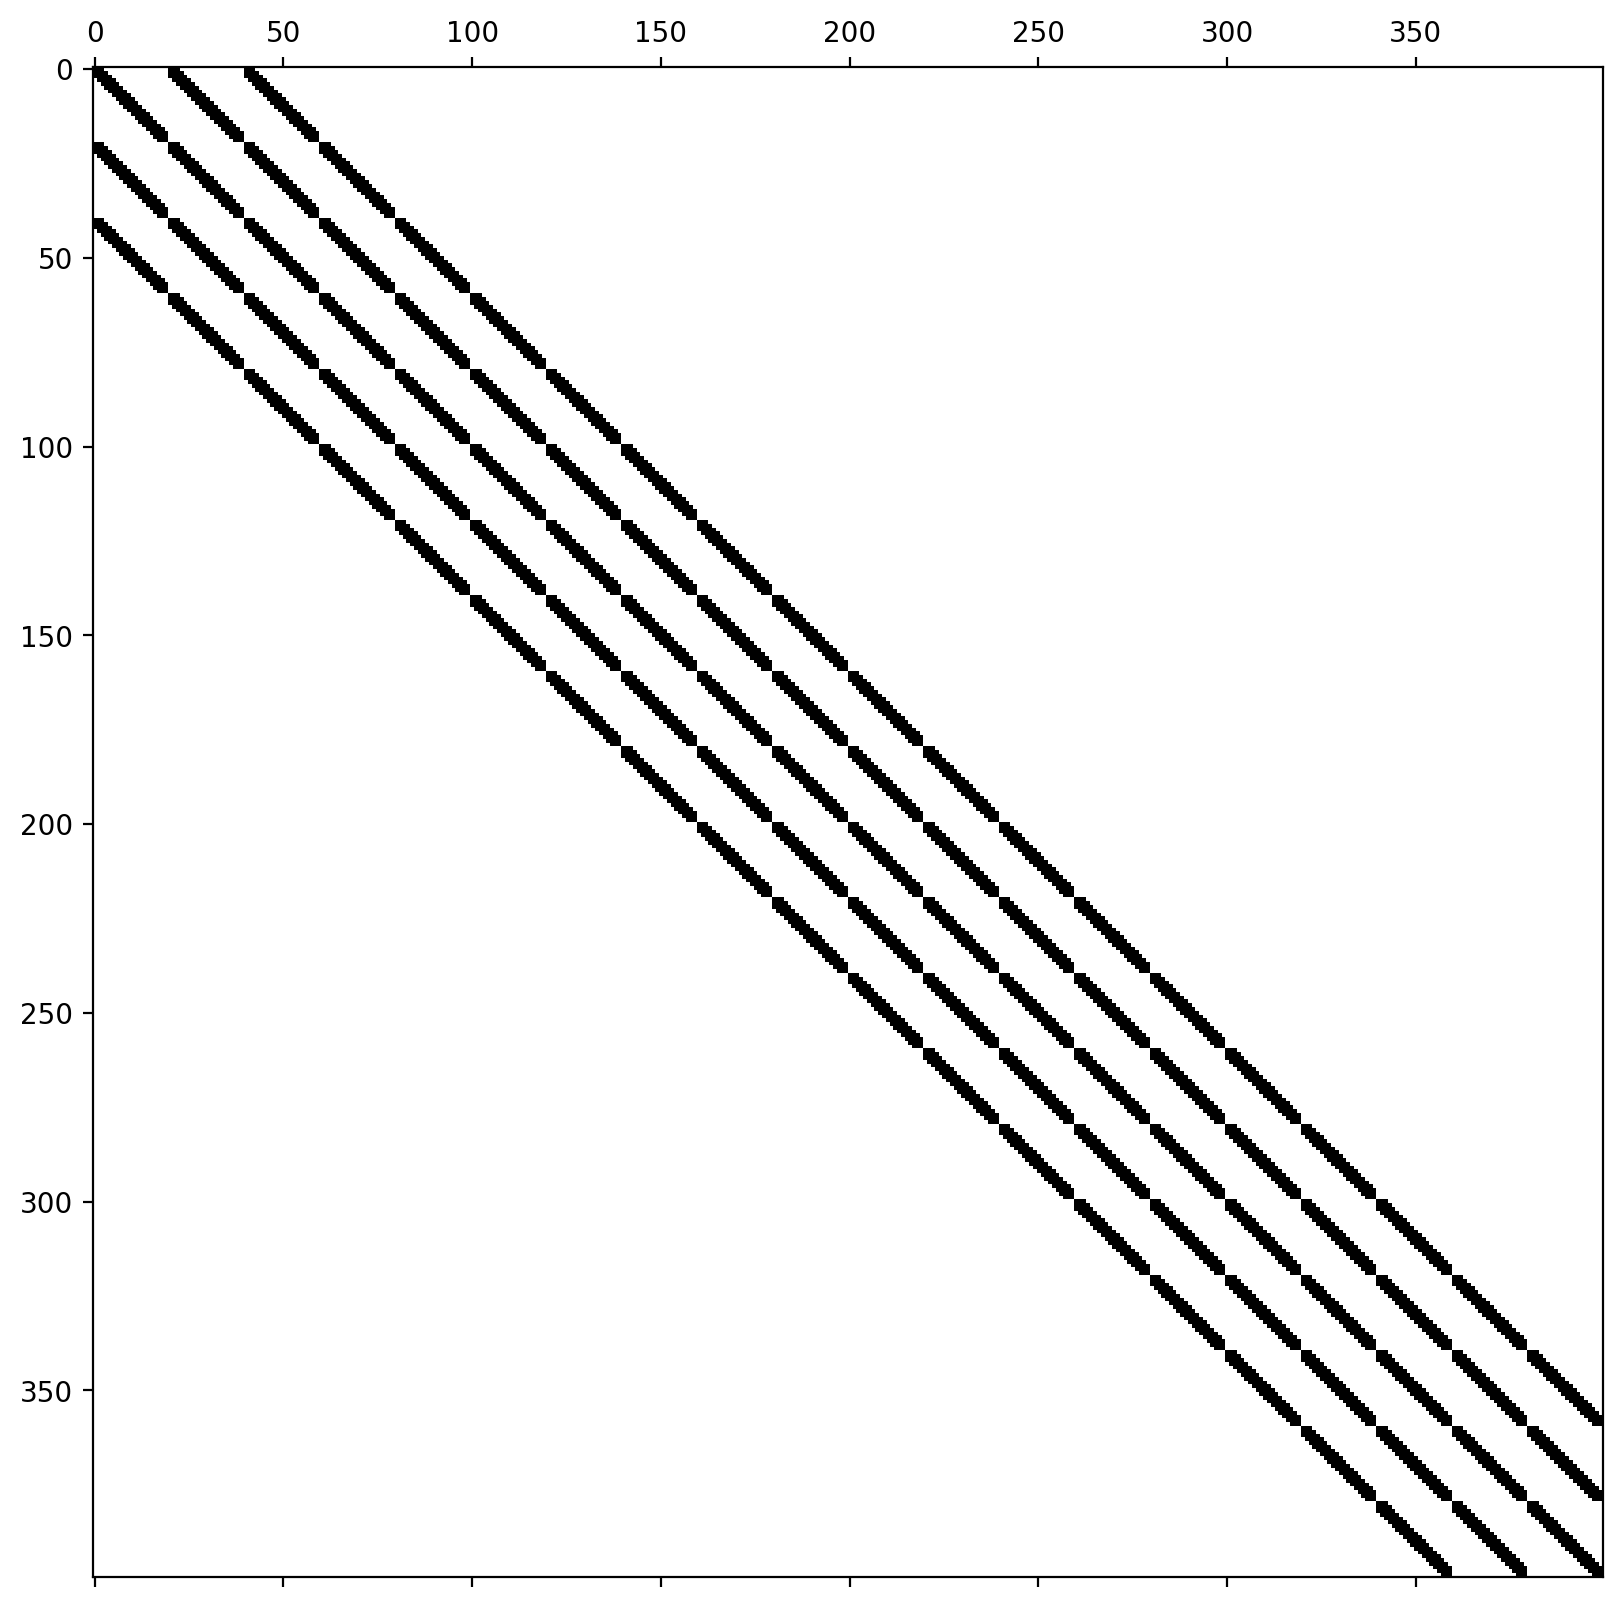

In [12]:
plt.spy(matrix_A)
plt.show()

# Ad 4

**Porównanie czasowe eliminacji rzadkiej i gęstej**

In [13]:
time_sparse = time_counter_sparse(matrix_A)
time_dense = time_counter_dense(matrix_A)

print("Czas eliminacji rzadkiej: ")
print(time_sparse)

print("\nCzas eliminacji gęstej: ")
print(time_dense)

Czas eliminacji rzadkiej: 
2.579307874999998

Czas eliminacji gęstej: 
8.496328457999994


**Wykres czasów**

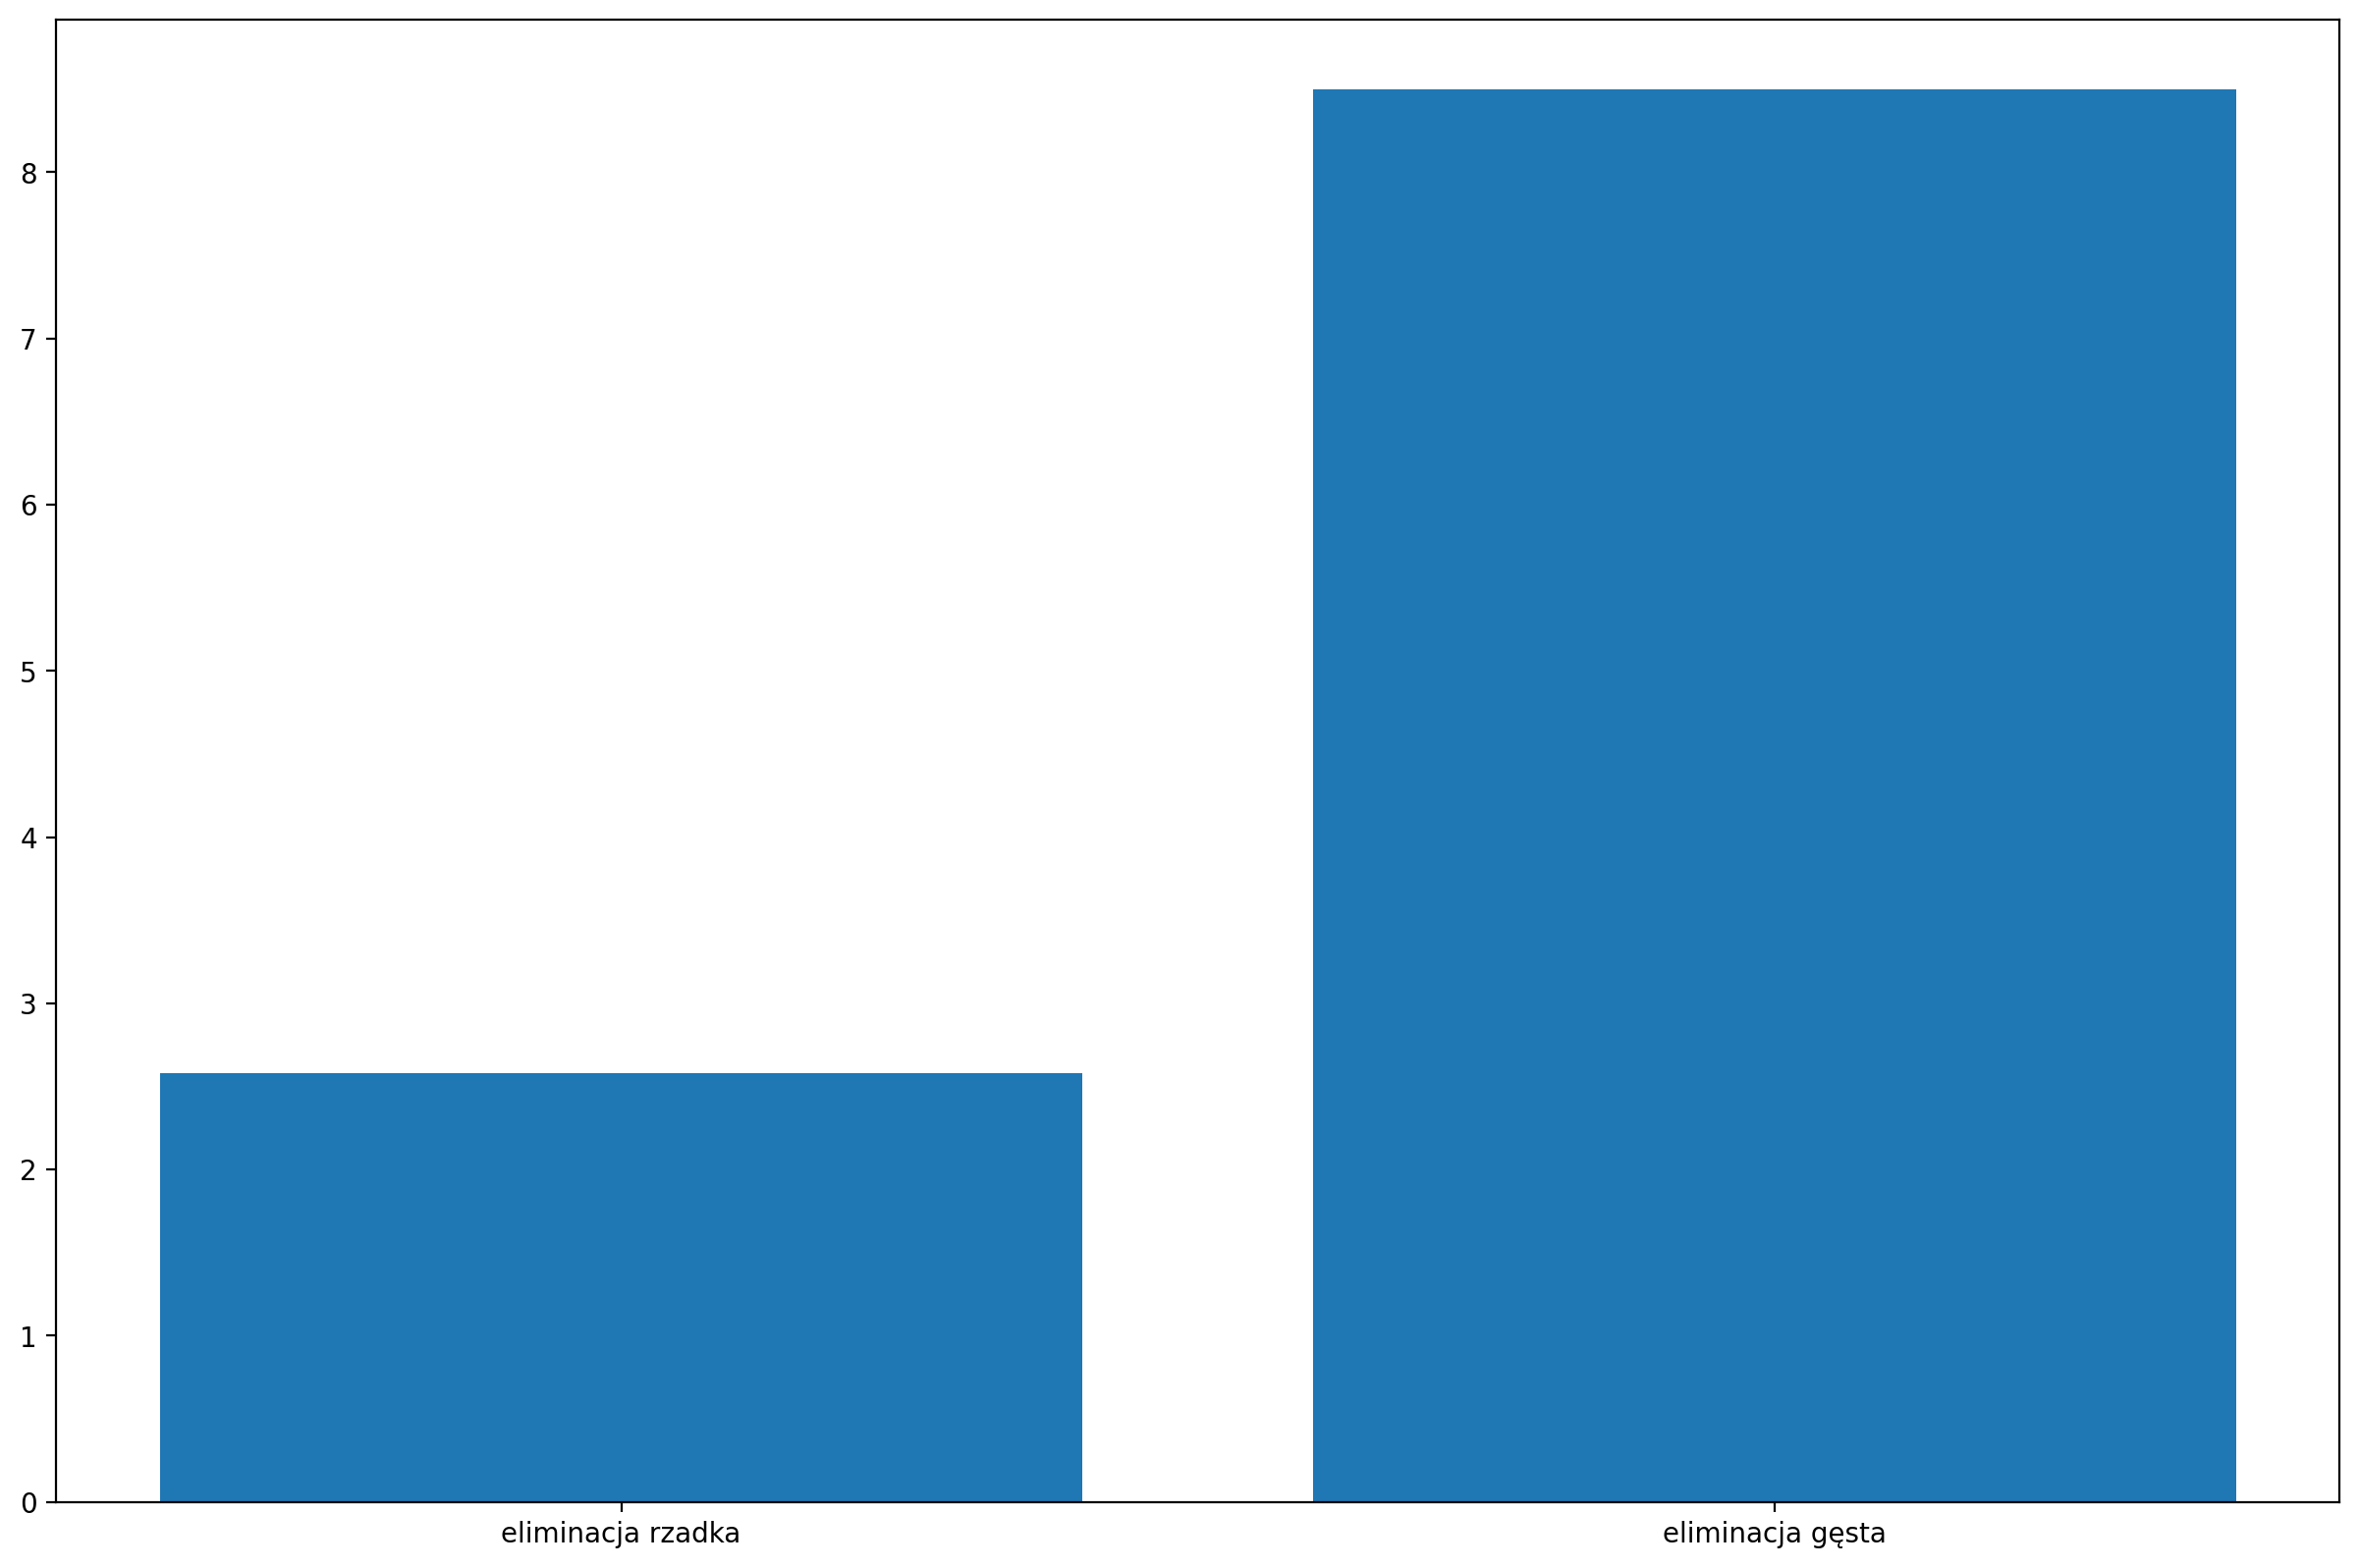

In [14]:
plt.bar(["eliminacja rzadka", "eliminacja gęsta"], [time_sparse, time_dense])
plt.show()

# Ad 5

**Porównanie zużycia pamięci eliminacji rzadkiej i gęstej**

In [15]:
csc_matrix = CSCMatrix(matrix_A)
colptr = np.array(csc_matrix.colptr)
irn = np.array(csc_matrix.irn)
vals =  np.array(csc_matrix.vals)
colptr_res, irn_res, vals_res = csc_gauss_elimination(matrix_A.shape[0], colptr, irn, vals)

memory_sparse = colptr_res.nbytes + irn_res.nbytes + vals_res.nbytes
print("Zużycie pamięci dla eliminacji rzadkiej: ")
print(memory_sparse)

matrix_res = dense_gauss_elimination(matrix_A)
memory_dense = matrix_res.nbytes
print("\nZużycie pamięci dla eliminacji gęstej: ")
print(memory_dense)

Zużycie pamięci dla eliminacji rzadkiej: 
77096

Zużycie pamięci dla eliminacji gęstej: 
1280000


**Wykres zużycia pamięci**

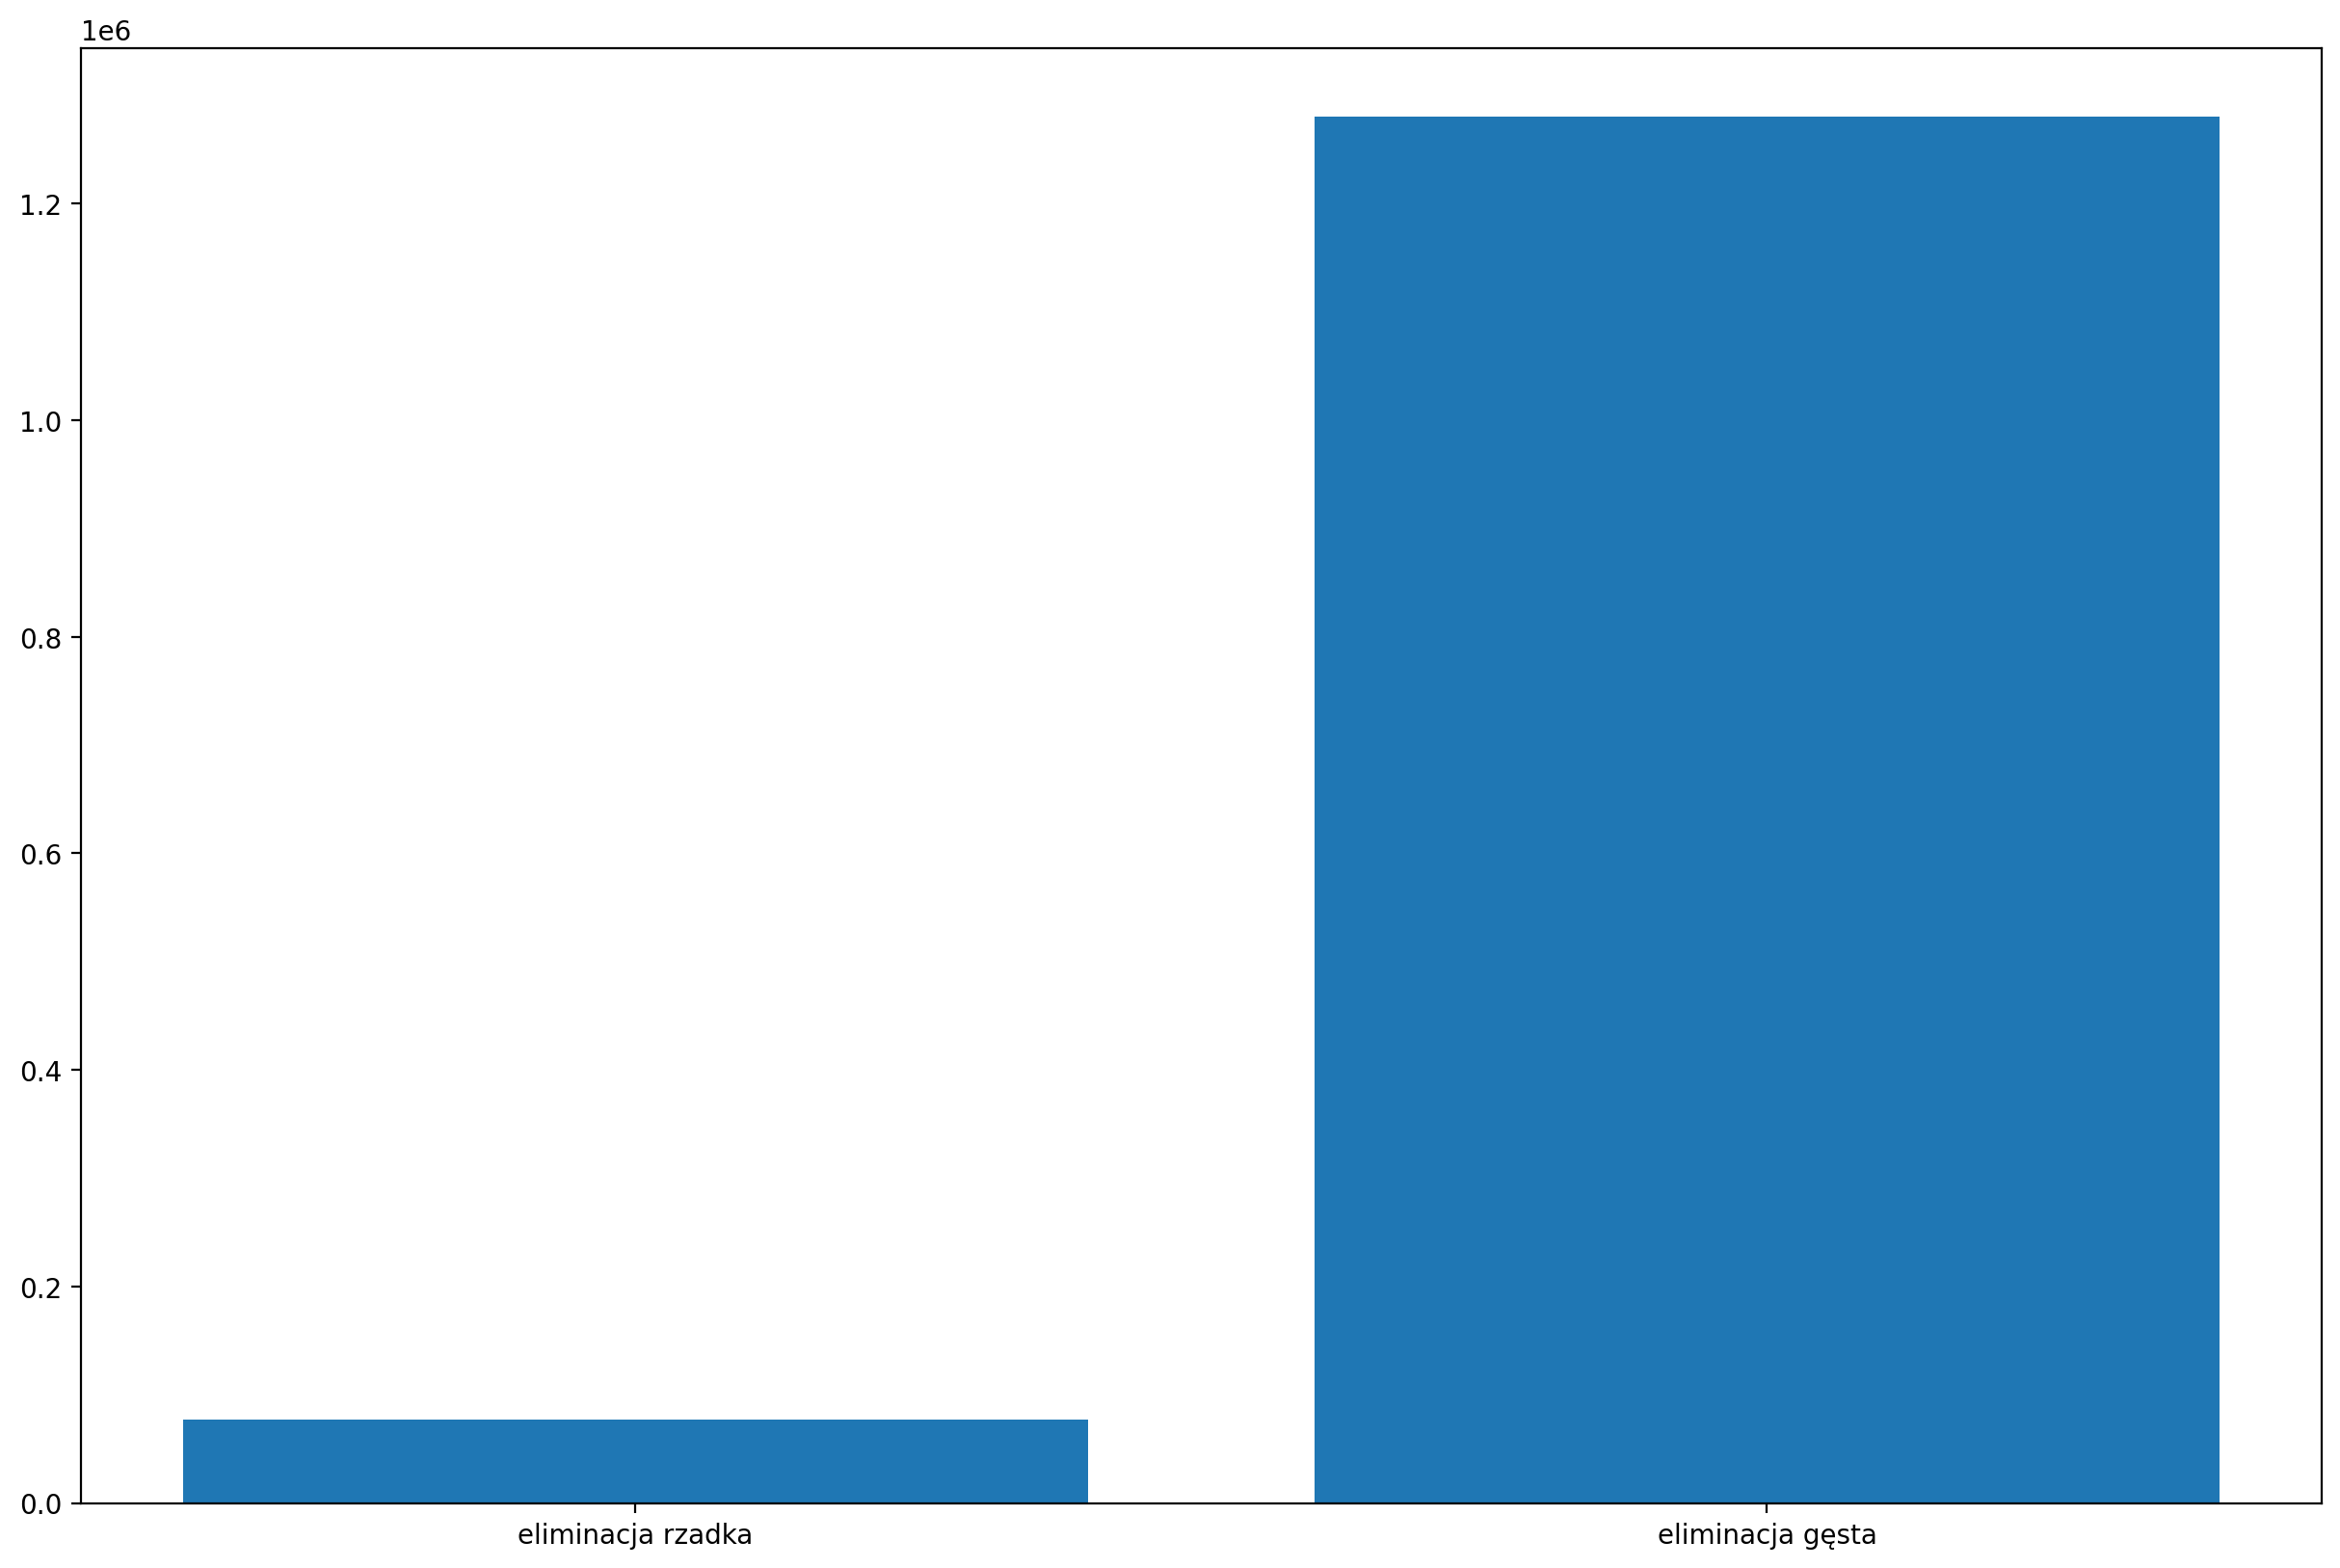

In [16]:
plt.bar(['eliminacja rzadka', 'eliminacja gęsta'], [memory_sparse, memory_dense])
plt.show()

# Ad 6

**Wczytywanie wygenerowanych macierzy**

In [17]:
matrix_B = pd.read_csv('matrix_B.csv', header=None, index_col=None).to_numpy()
matrix_C = pd.read_csv('matrix_C.csv', header=None, index_col=None).to_numpy()

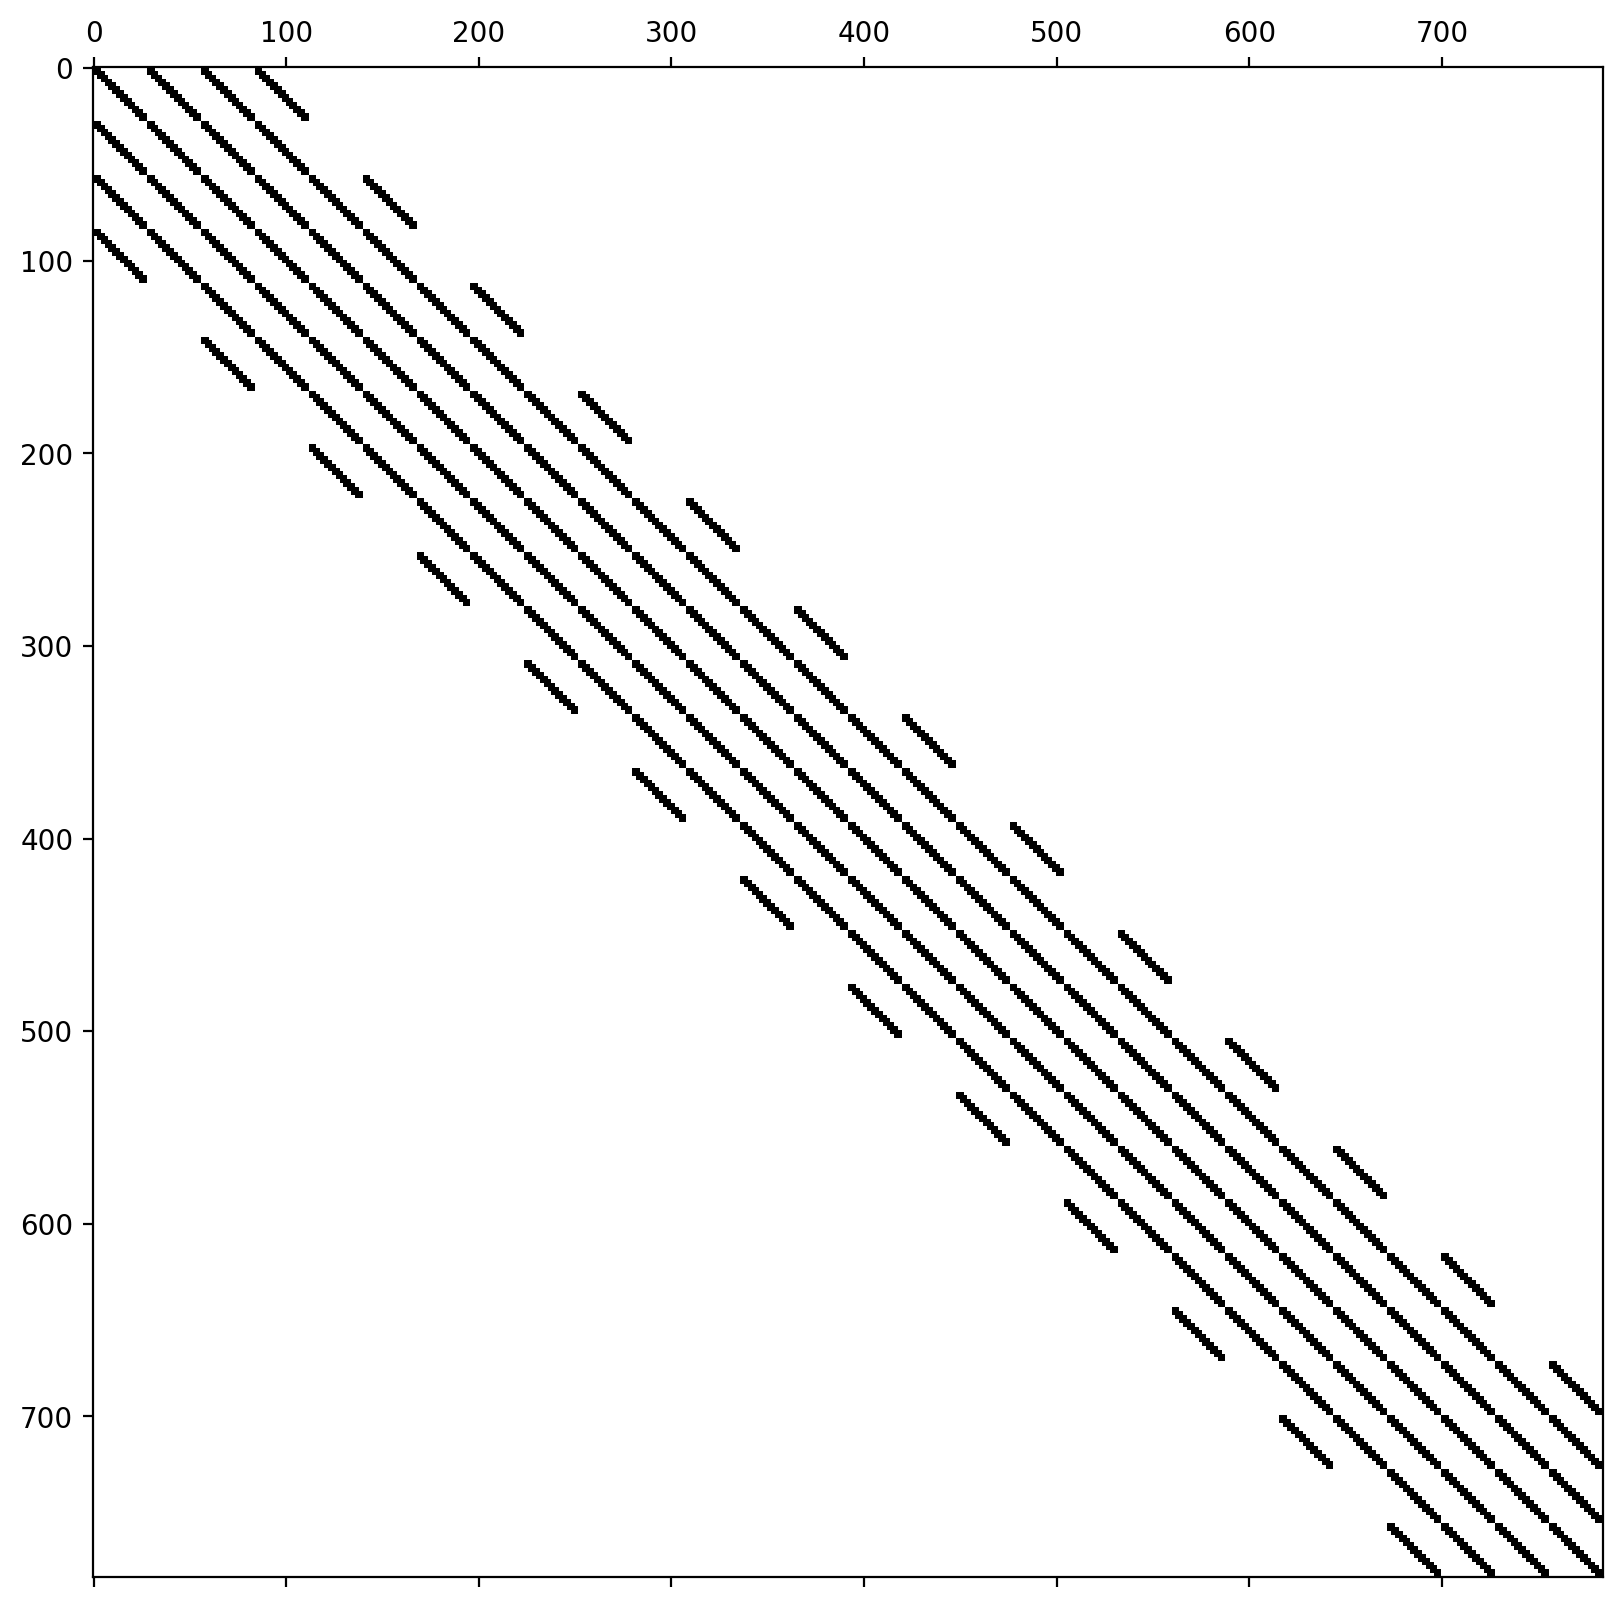

In [18]:
plt.spy(matrix_B)
plt.show()

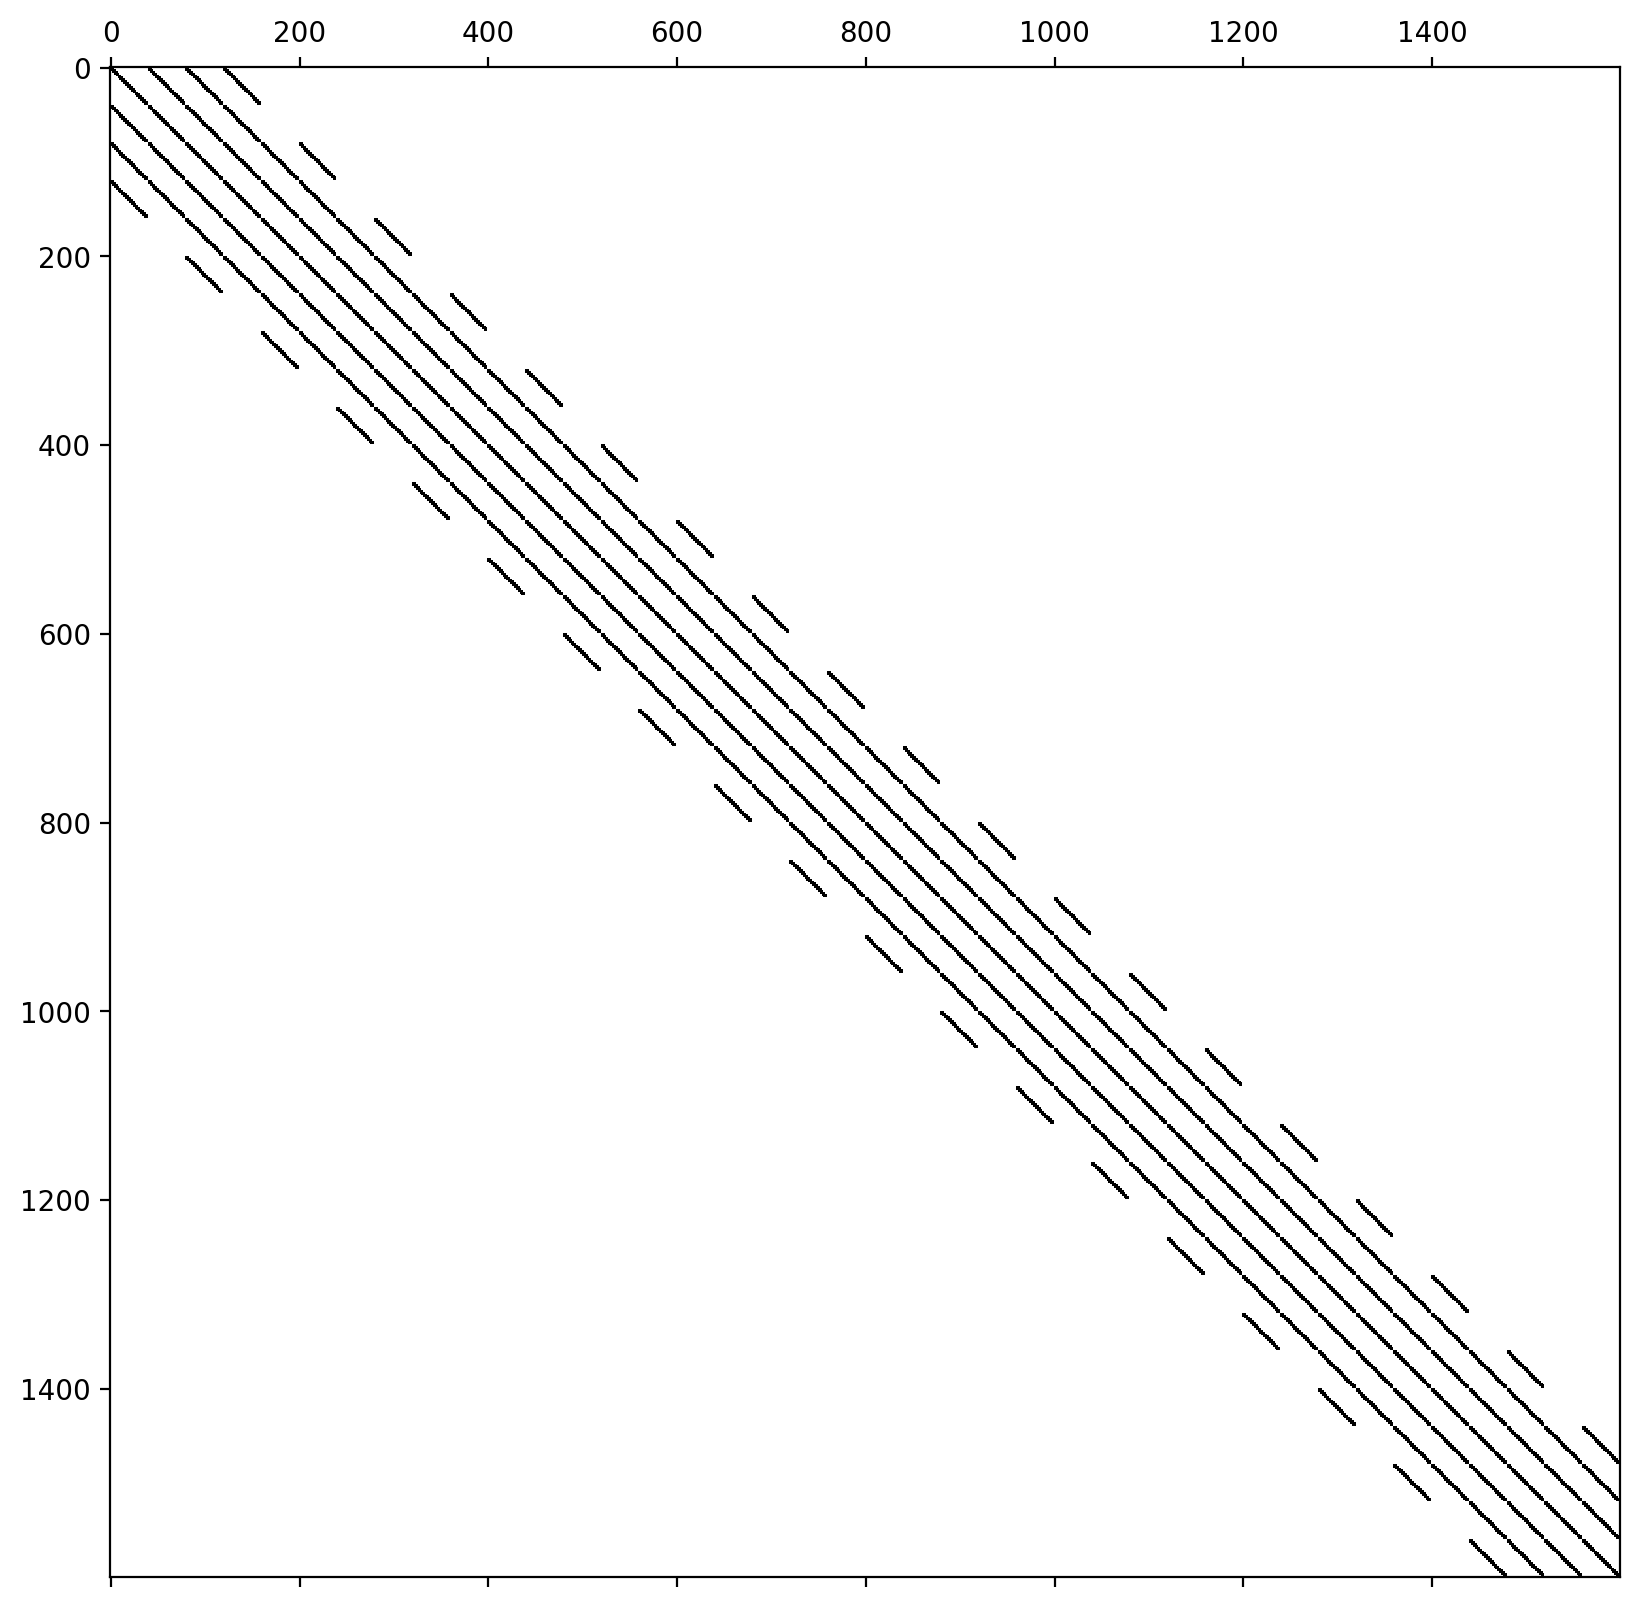

In [20]:
plt.spy(matrix_C)
plt.show()

# Ad 7

**Porównanie czasu działania eliminacji rzadkiej i gęstej**

## Porównanie dla macierzy 784 x 784:

In [21]:
time_sparse = time_counter_sparse(matrix_B)
time_dense = time_counter_dense(matrix_B)

print("Czas eliminacji rzadkiej: ")
print(time_sparse)

print("\nCzas eliminacji gęstej: ")
print(time_dense)

Czas eliminacji rzadkiej: 
16.44595908299999

Czas eliminacji gęstej: 
63.909373042


**Wykres czasów**

<BarContainer object of 2 artists>

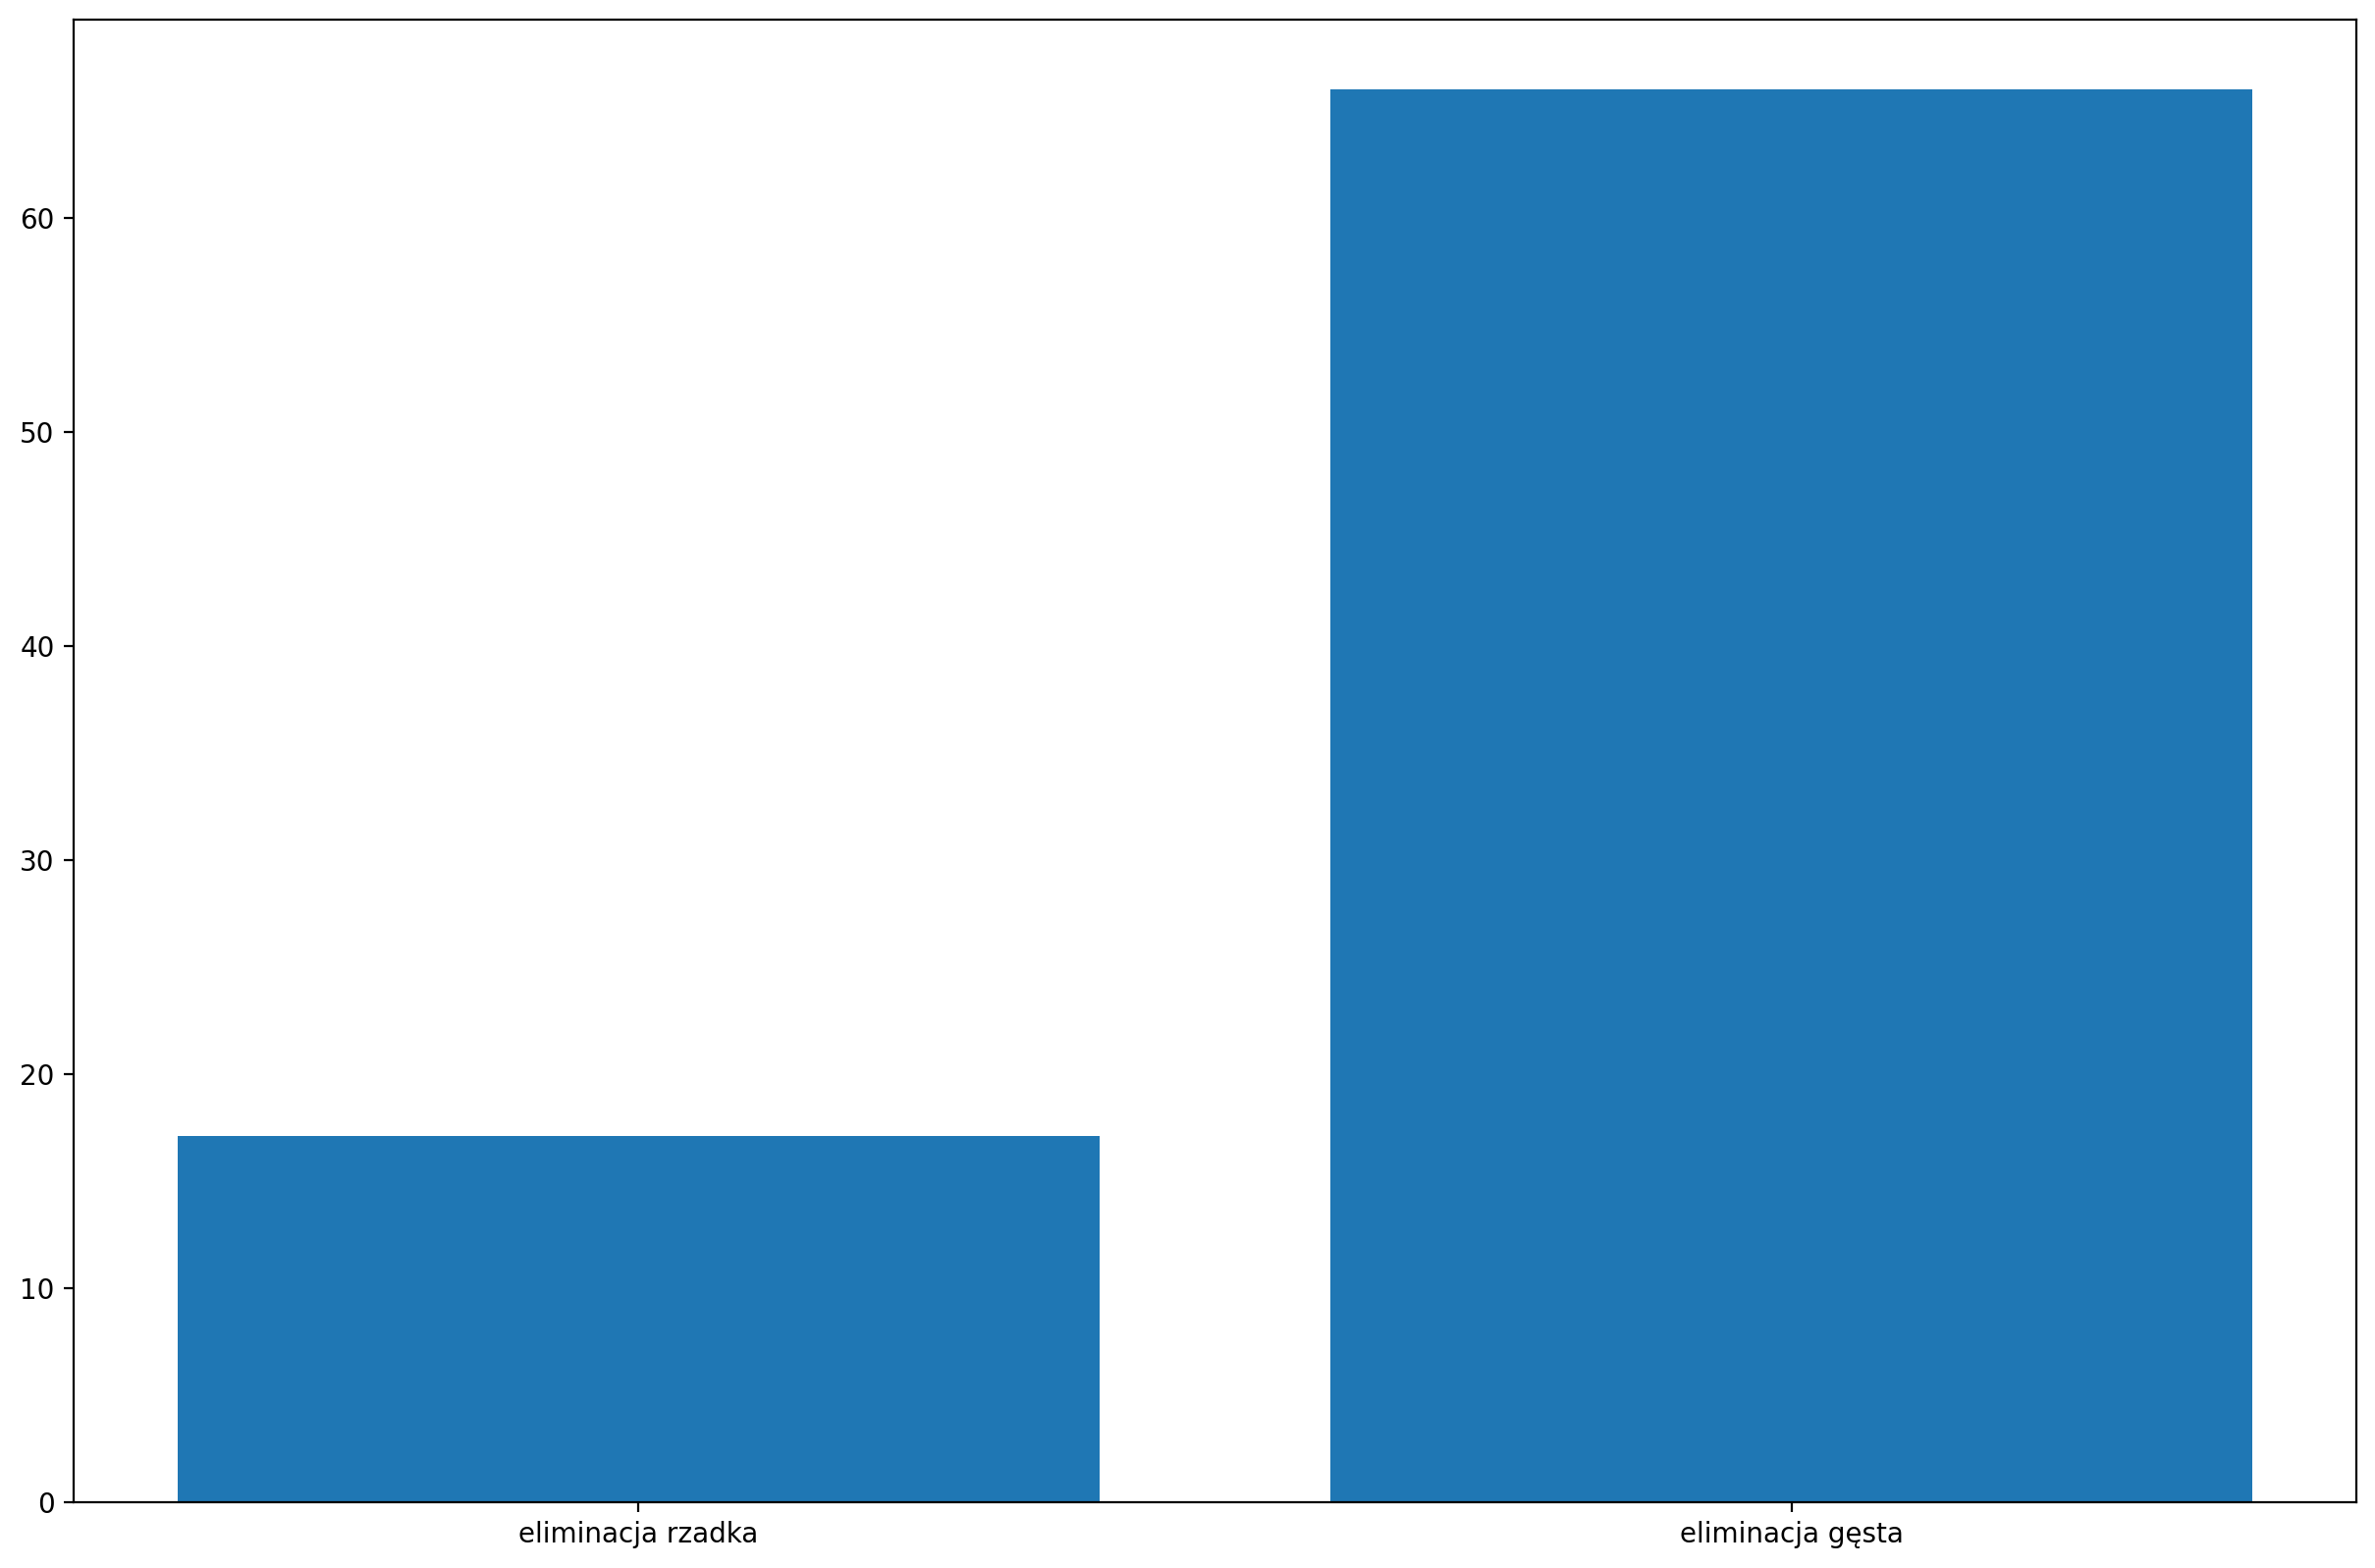

In [171]:
plt.bar(["eliminacja rzadka", "eliminacja gęsta"], [time_sparse, time_dense])
plt.show()

## Porównanie dla macierzy 1600 x 1600

In [23]:
time_sparse = time_counter_sparse(matrix_C)
time_dense = time_counter_dense(matrix_C)

print("Czas eliminacji rzadkiej: ")
print(time_sparse)

print("\nCzas eliminacji gęstej: ")
print(time_dense)

Czas eliminacji rzadkiej: 
92.78884695900001

Czas eliminacji gęstej: 
556.622794792


**Wykres czasów**

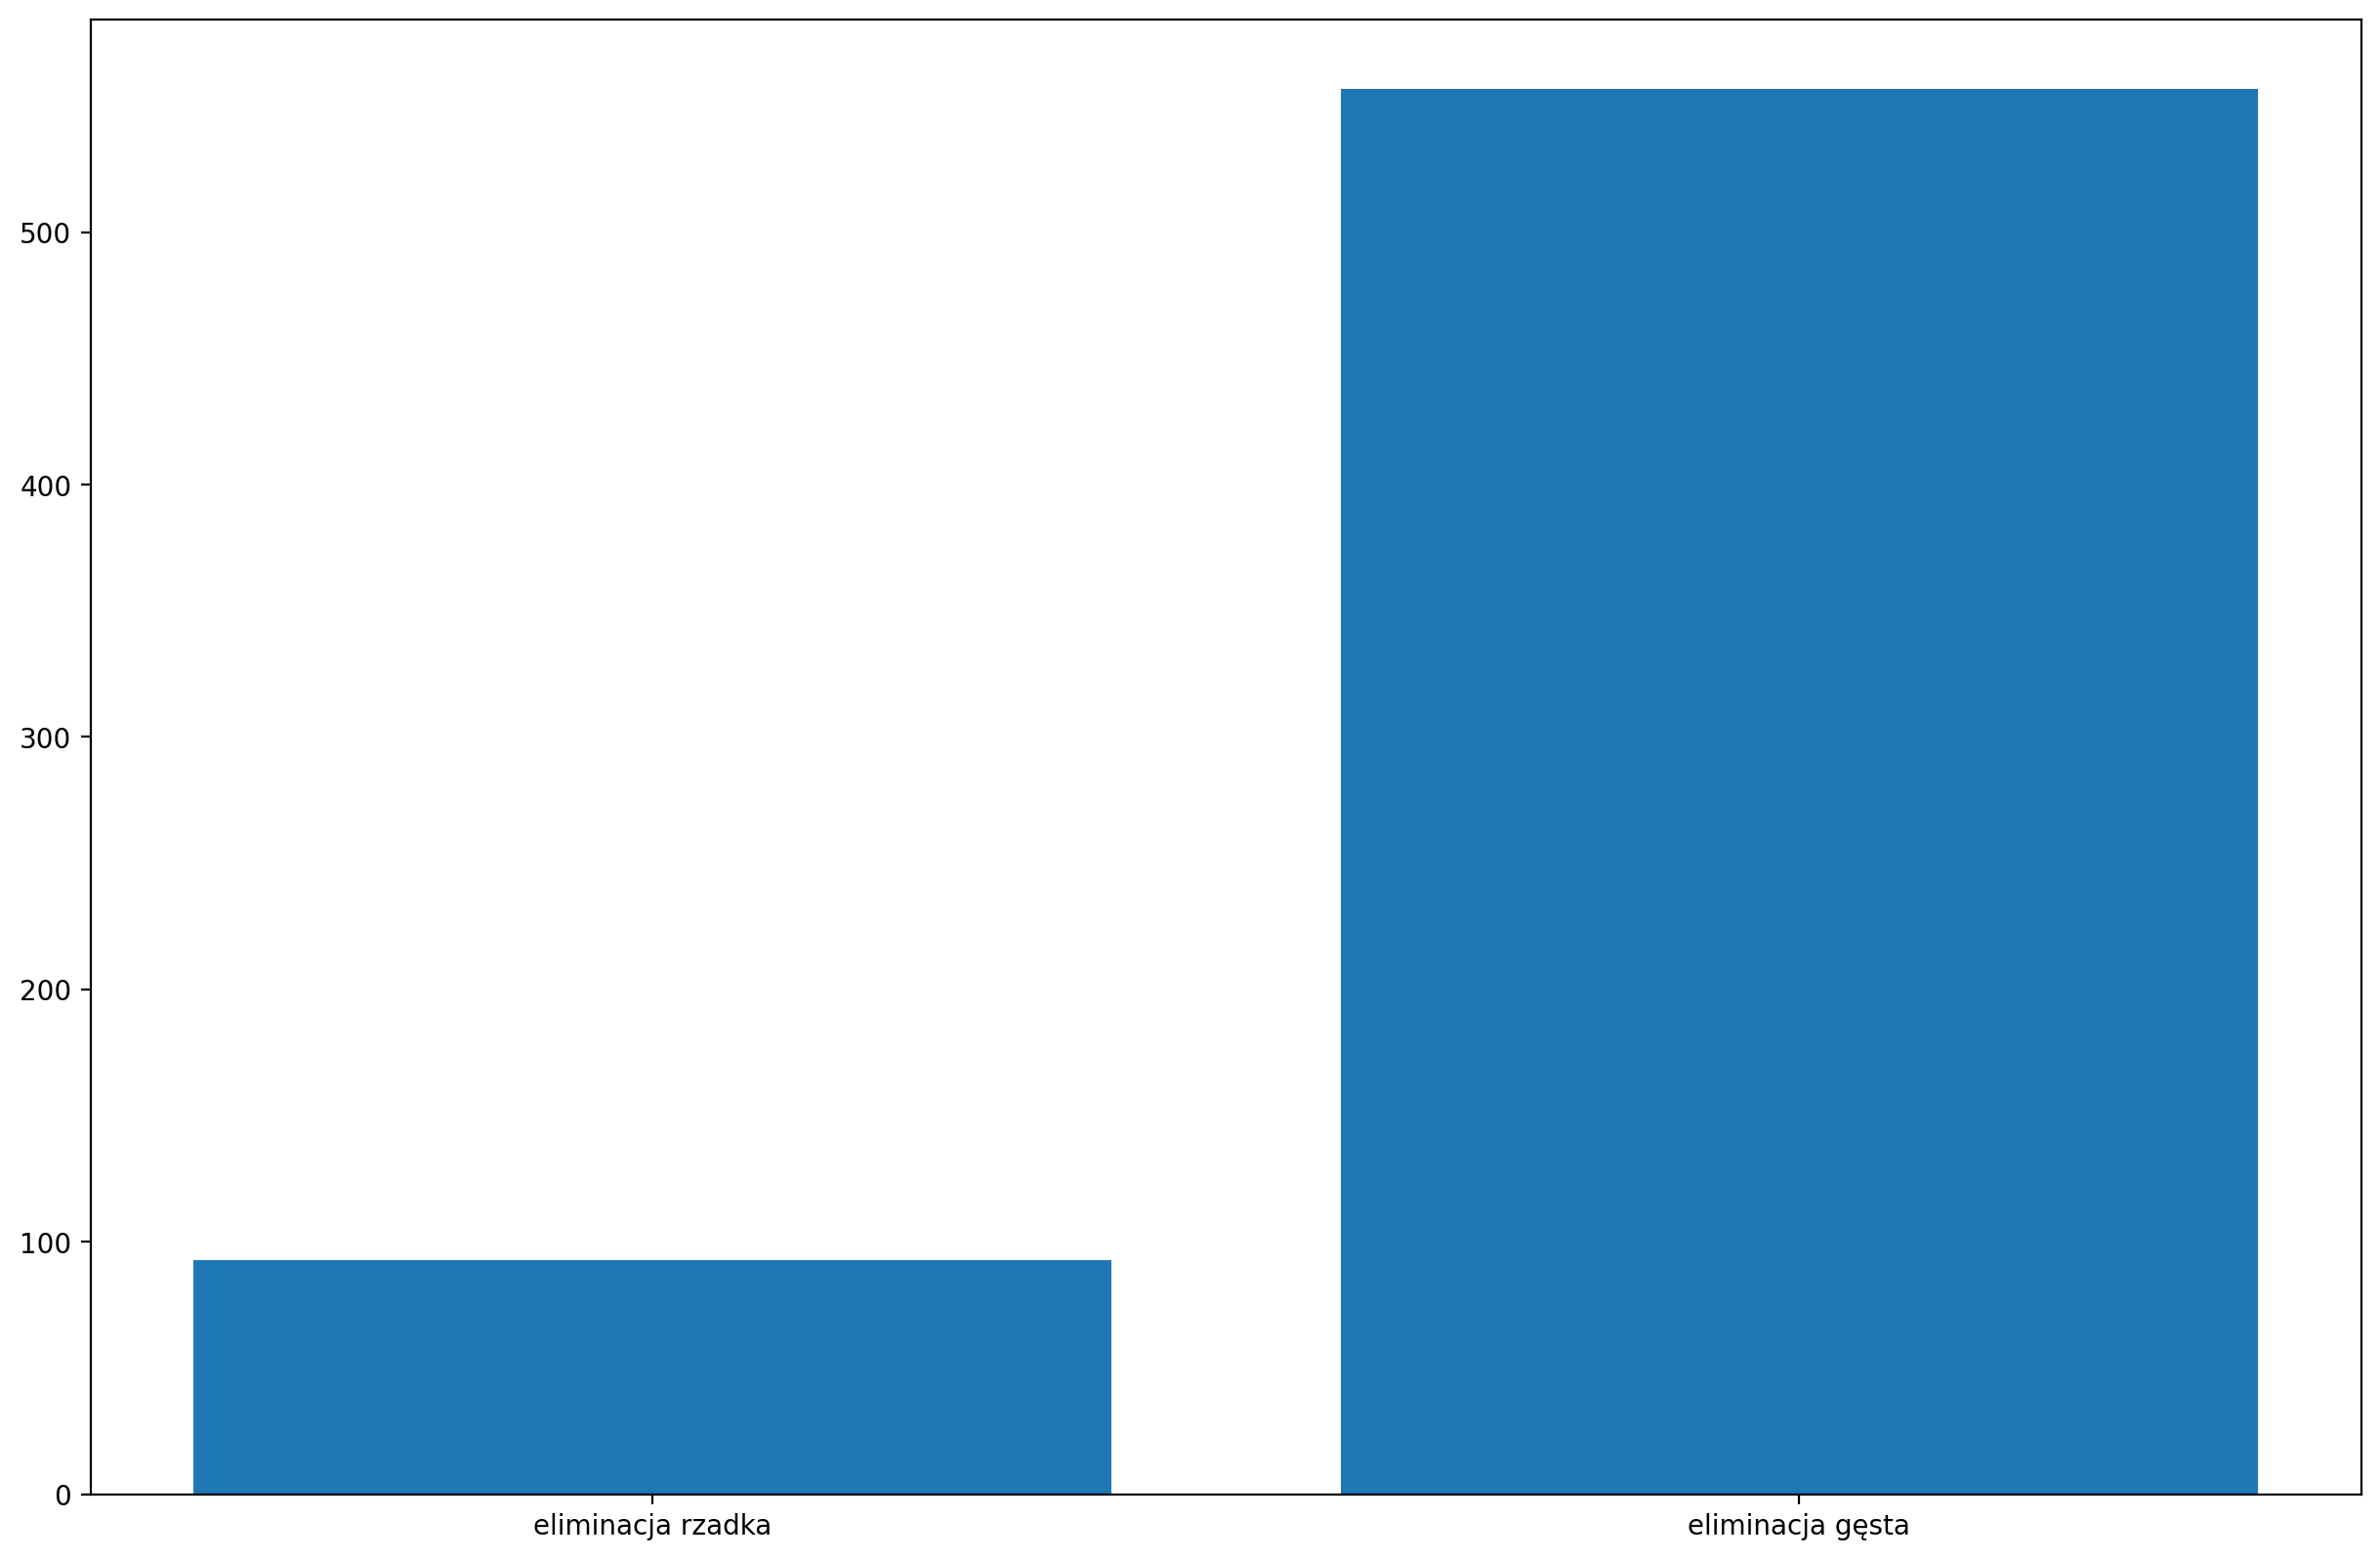

In [24]:
plt.bar(["eliminacja rzadka", "eliminacja gęsta"], [time_sparse, time_dense])
plt.show()

# Ad 8

**Porównanie zużycia pamięci eliminacji rzadkiej i gęstej**

In [25]:
csc_matrix = CSCMatrix(matrix_B)
colptr = np.array(csc_matrix.colptr)
irn = np.array(csc_matrix.irn)
vals =  np.array(csc_matrix.vals)
colptr_res, irn_res, vals_res = csc_gauss_elimination(matrix_B.shape[0], colptr, irn, vals)

memory_sparse = colptr_res.nbytes + irn_res.nbytes + vals_res.nbytes
print("Zużycie pamięci dla eliminacji rzadkiej: ")
print(memory_sparse)

matrix_res = dense_gauss_elimination(matrix_B)
memory_dense = matrix_res.nbytes
print("\nZużycie pamięci dla eliminacji gęstej: ")
print(memory_dense)

Zużycie pamięci dla eliminacji rzadkiej: 
217352

Zużycie pamięci dla eliminacji gęstej: 
4917248


**Wykres zużycia pamięci**

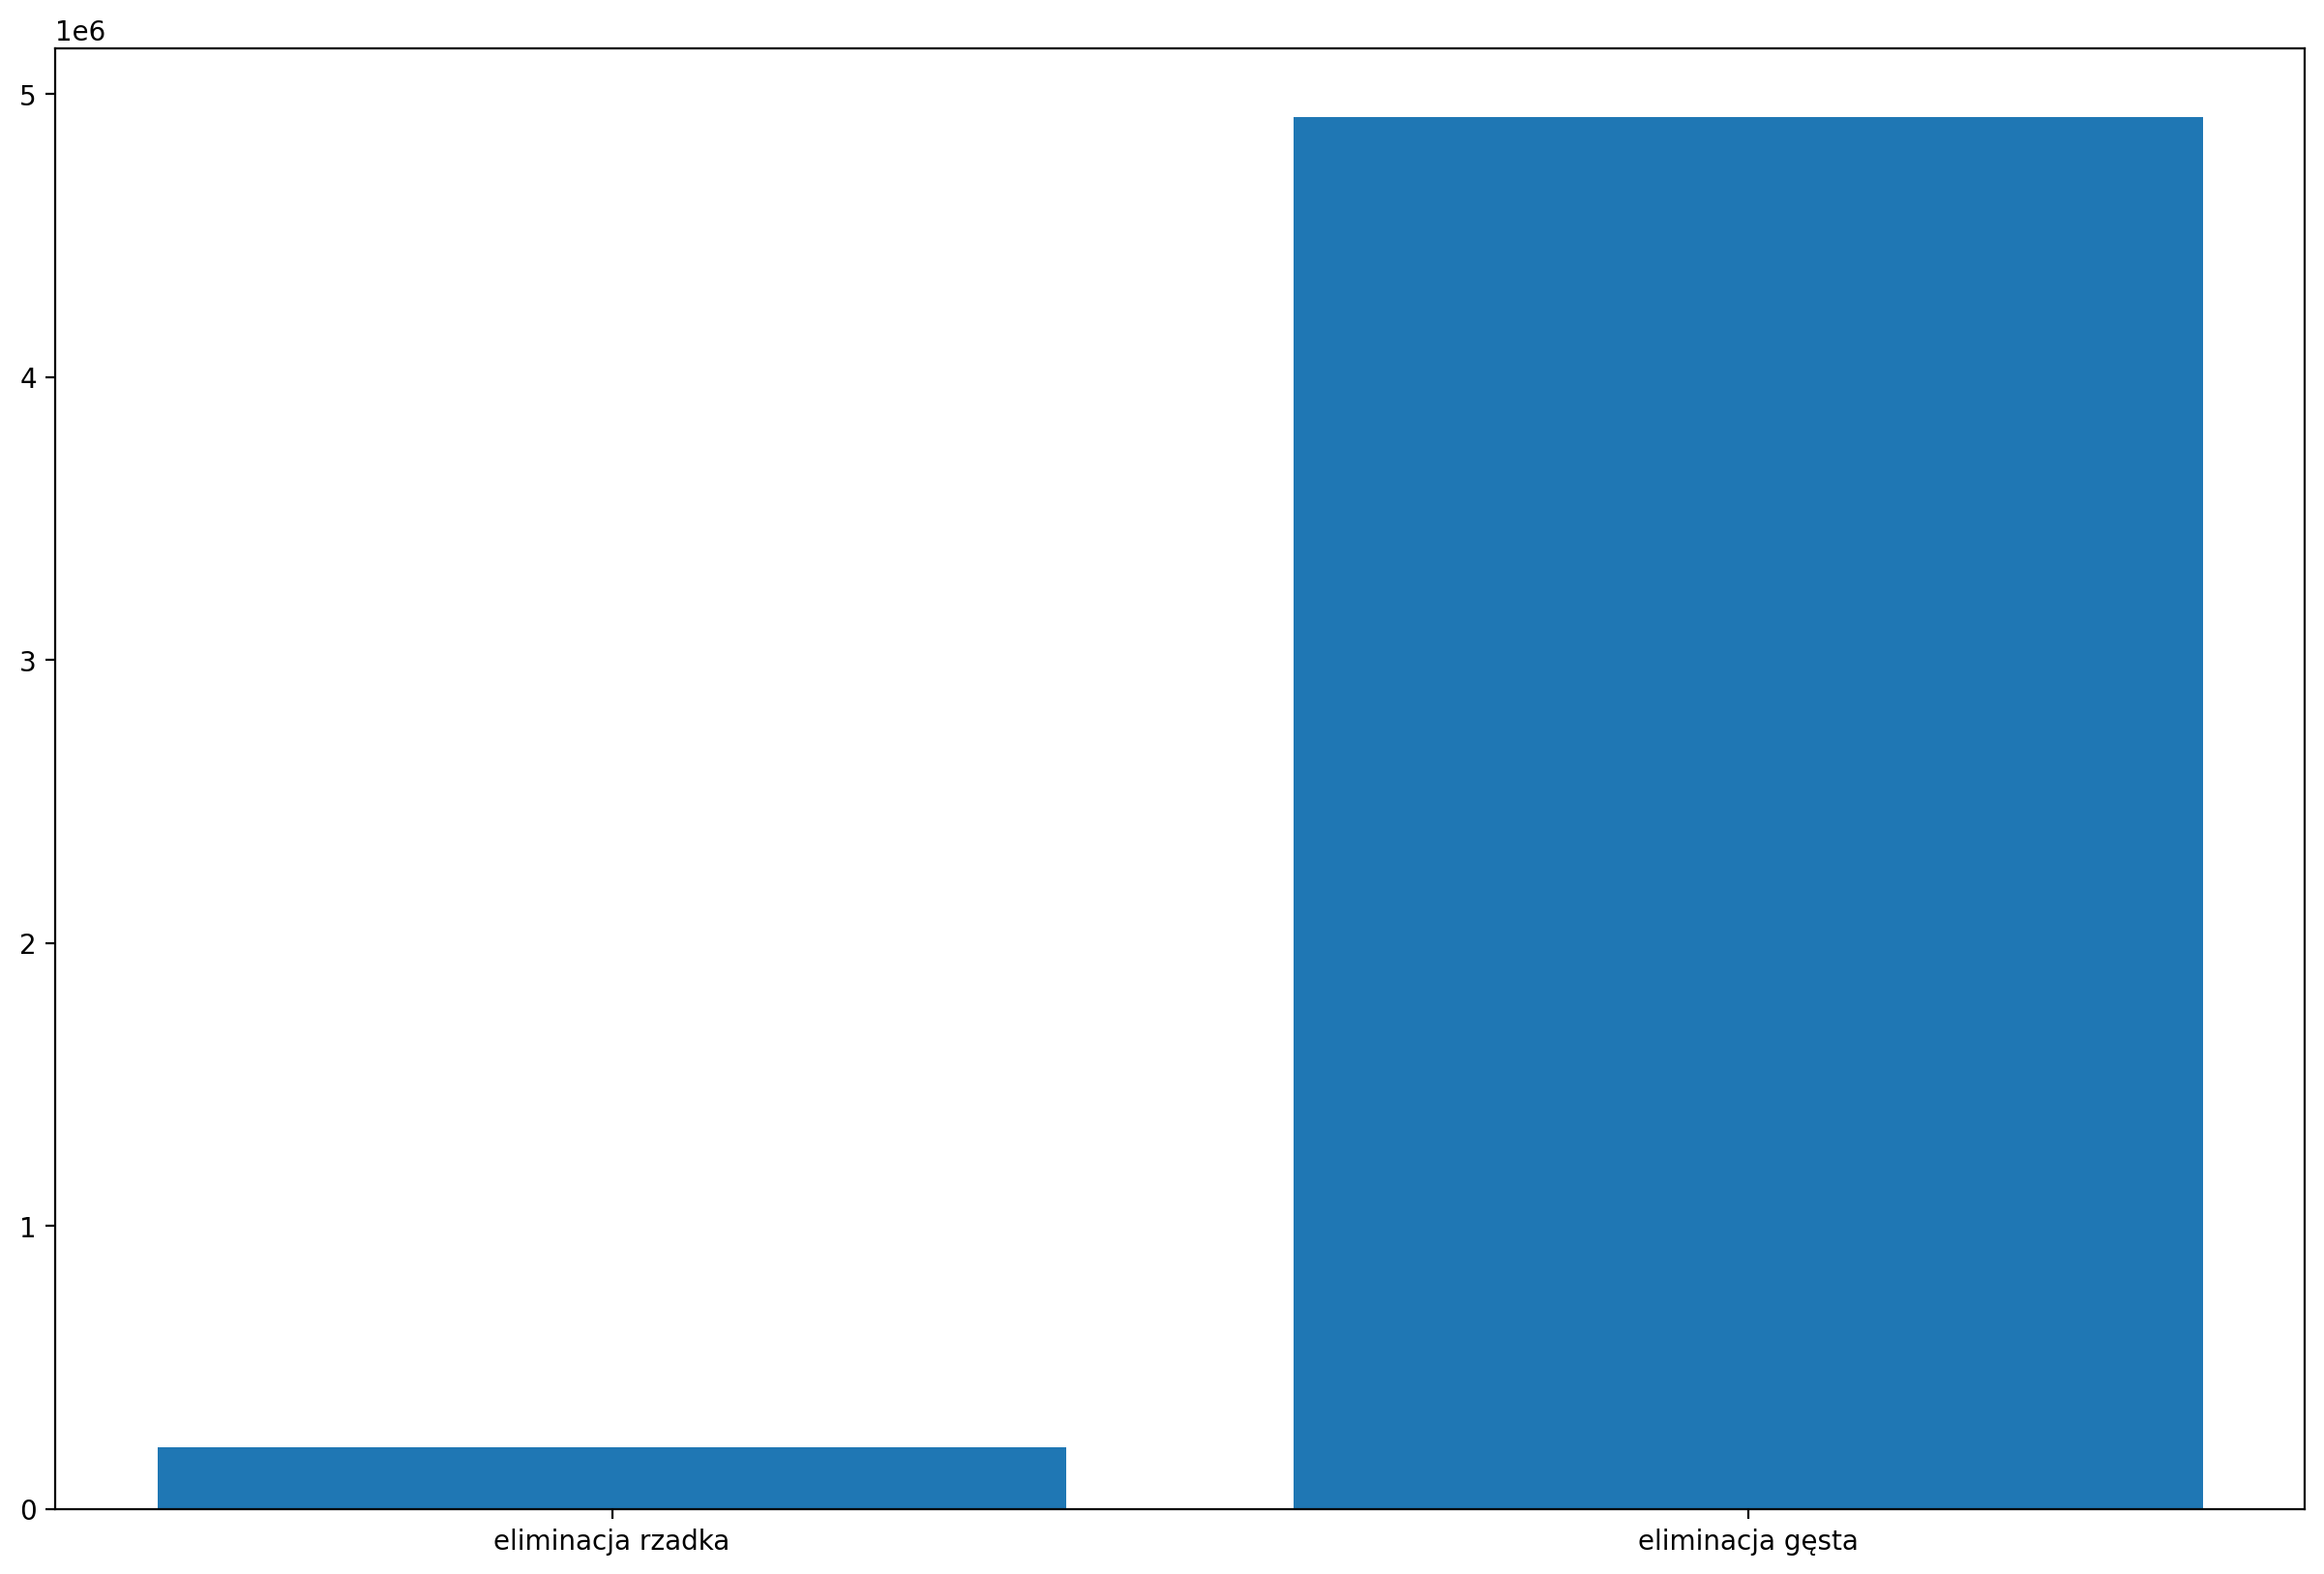

In [26]:
plt.bar(["eliminacja rzadka", "eliminacja gęsta"], [memory_sparse, memory_dense])
plt.show()

In [29]:
csc_matrix = CSCMatrix(matrix_C)
colptr = np.array(csc_matrix.colptr)
irn = np.array(csc_matrix.irn)
vals =  np.array(csc_matrix.vals)
colptr_res, irn_res, vals_res = csc_gauss_elimination(matrix_C.shape[0], colptr, irn, vals)

memory_sparse = colptr_res.nbytes + irn_res.nbytes + vals_res.nbytes
print("Zużycie pamięci dla eliminacji rzadkiej: ")
print(memory_sparse)

matrix_res = dense_gauss_elimination(matrix_C)
memory_dense = matrix_res.nbytes
print("\nZużycie pamięci dla eliminacji gęstej: ")
print(memory_dense)

Zużycie pamięci dla eliminacji rzadkiej: 
456200

Zużycie pamięci dla eliminacji gęstej: 
20480000


**Wykres zużycia pamięci**

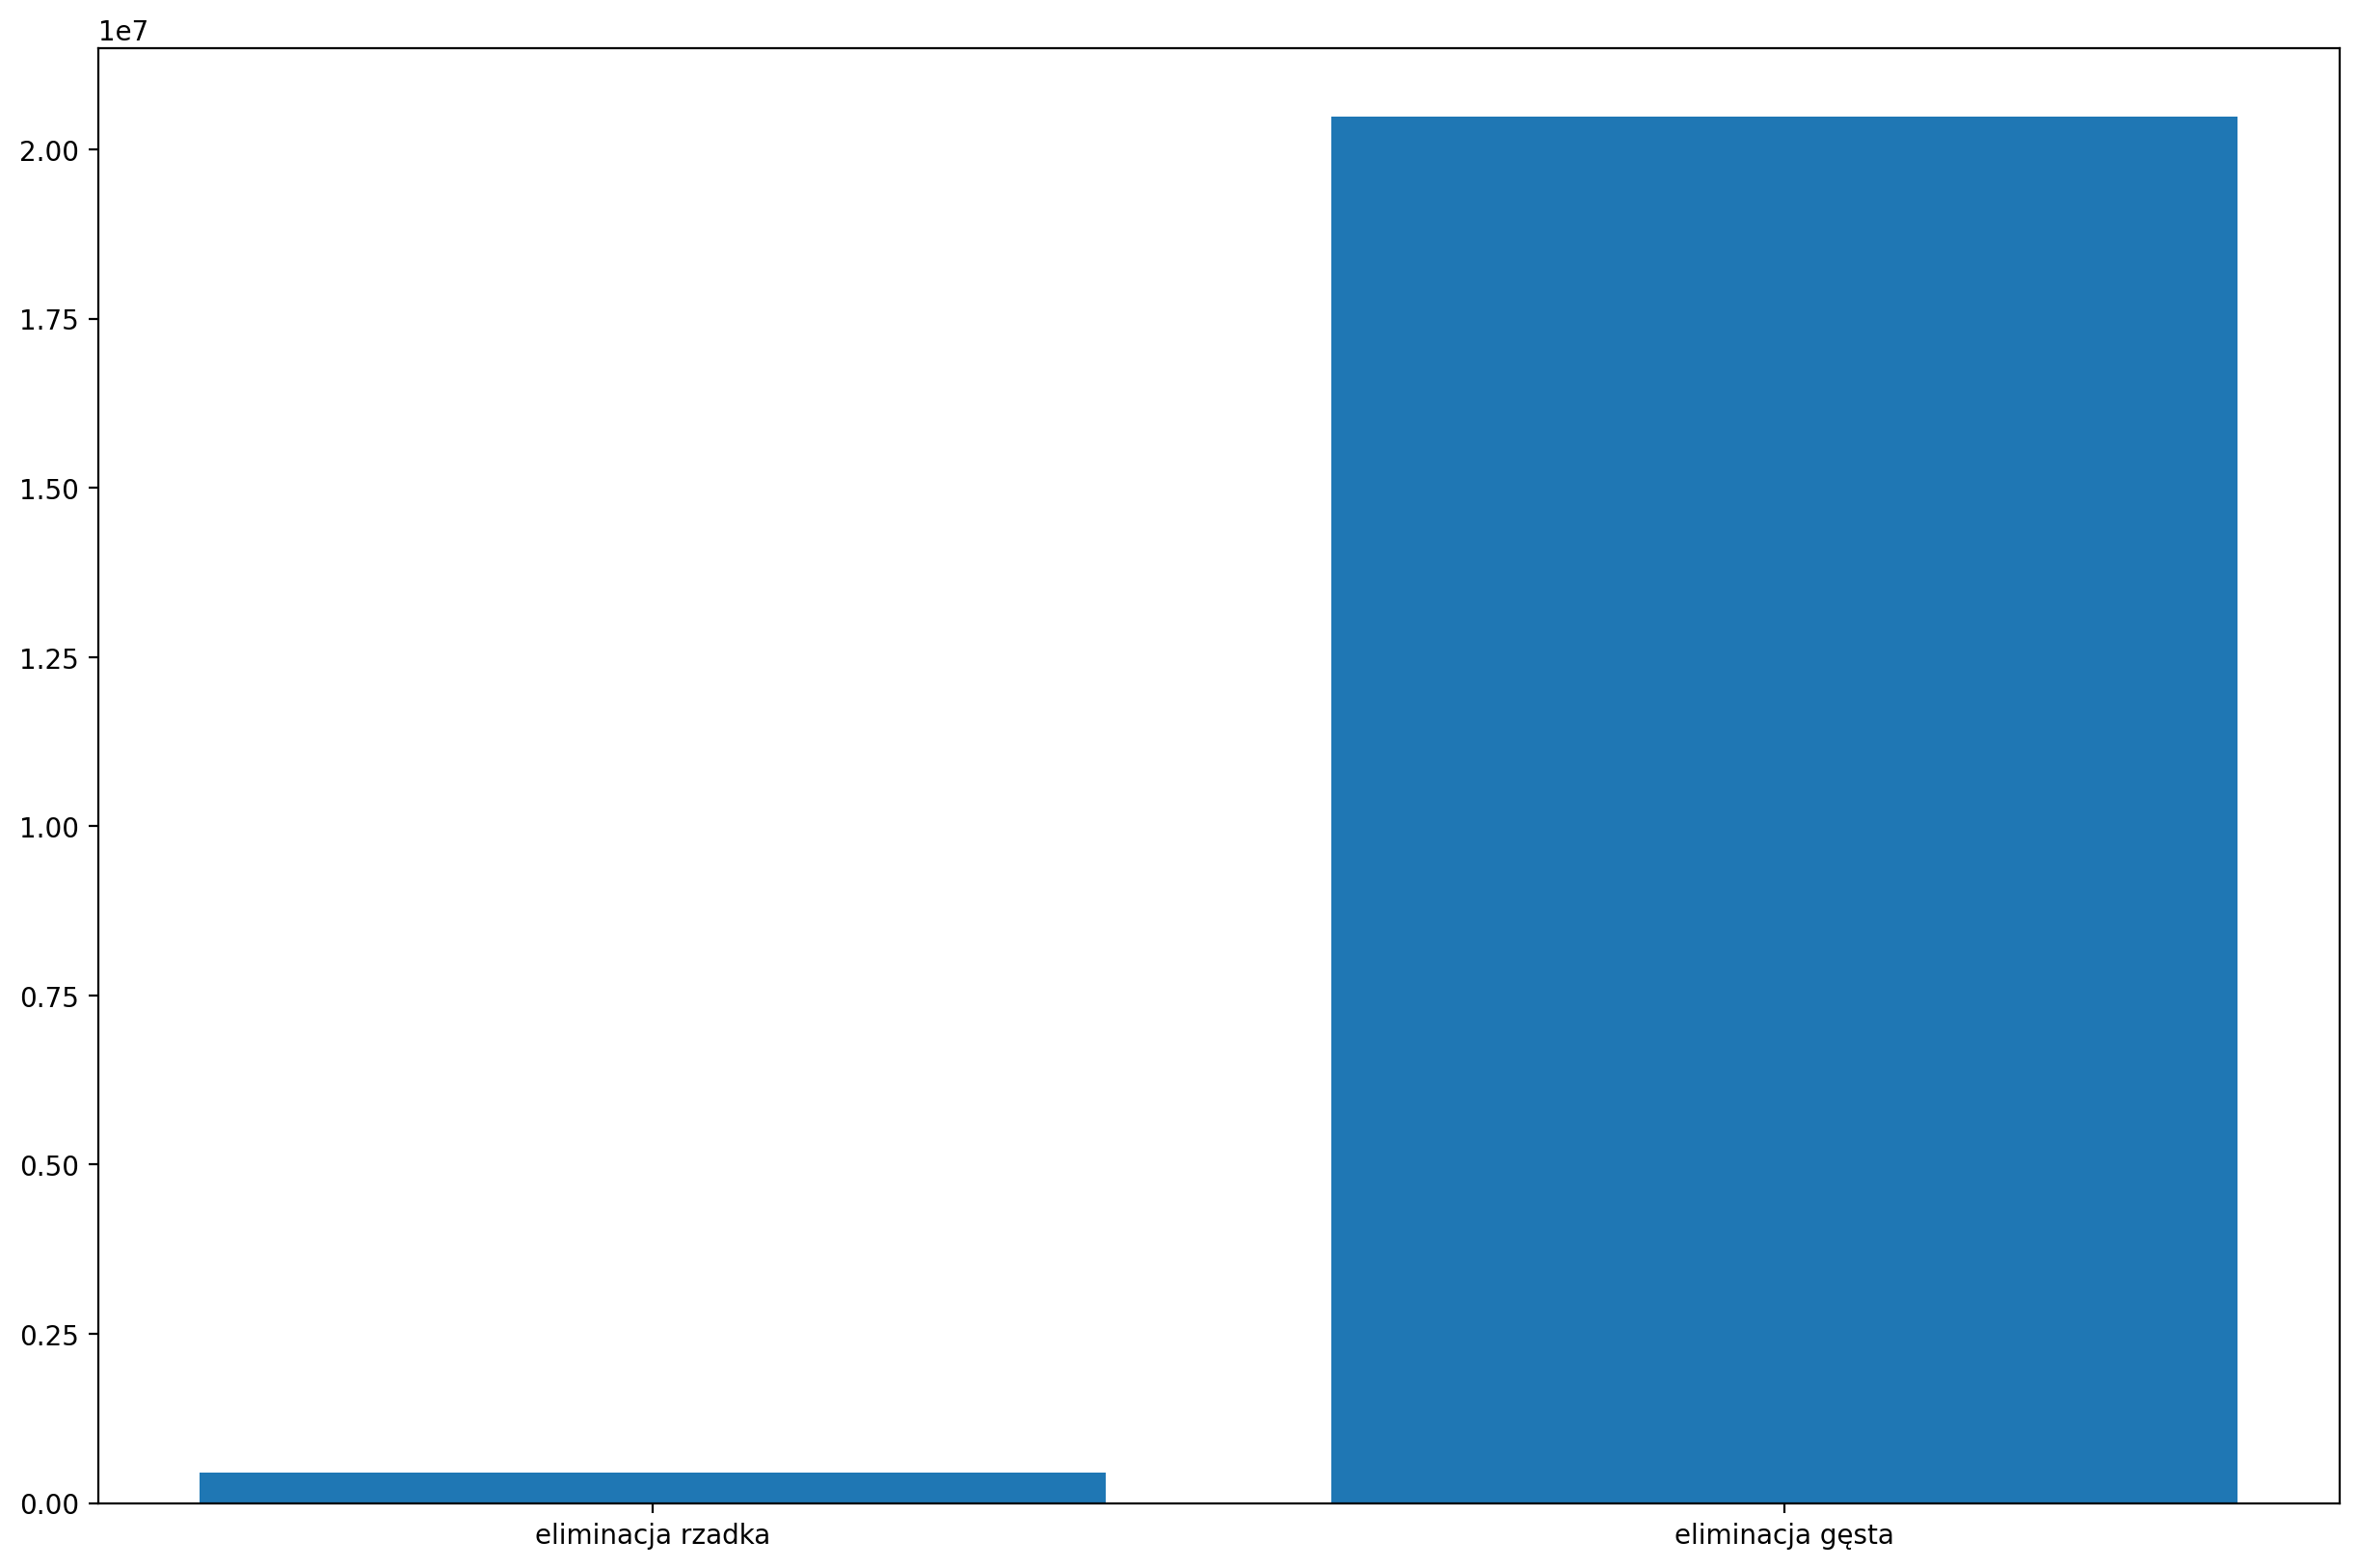

In [30]:
plt.bar(["eliminacja rzadka", "eliminacja gęsta"], [memory_sparse, memory_dense])
plt.show()

# Wnioski

**Czas działania:**

Dla wszystkich przypadków algorytm rzadkiej eliminacji Gaussa osiągał kilkukrotnie (około 3-6 razy) krótsze czasy.

**Zużycie pamięci:**

W przypadku zużycia pamięci mamy podobną sytuację - eliminacja gęsta zużywa o 1-2 rzędy wielkości więcej pamięci, niż eliminacja w wersji rzadkiej.